# ResNet50迁移学习

在实际应用场景中，由于训练数据集不足，所以很少有人会从头开始训练整个网络。普遍的做法是，在一个非常大的基础数据集上训练得到一个预训练模型，然后使用该模型来初始化网络的权重参数或作为固定特征提取器应用于特定的任务中。本案例将使用迁移学习的方法对ImageNet数据集中的狼和狗图像进行分类。


## 环境准备

开发者拿到香橙派开发板后，首先需要进行硬件资源确认，镜像烧录及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

- 硬件： 香橙派AIpro 8G 8T开发板
- 镜像： 香橙派官网ubuntu镜像
- CANN：8.1.RC1
- MindSpore： 2.6.0

### 镜像烧录

运行该案例需要烧录香橙派官网ubuntu镜像，烧录流程参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--镜像烧录](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/orange_pi/environment_setup.html#1-%E9%95%9C%E5%83%8F%E7%83%A7%E5%BD%95%E4%BB%A5windows%E7%B3%BB%E7%BB%9F%E4%B8%BA%E4%BE%8B)章节。

### CANN升级

CANN升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--CANN升级](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/orange_pi/environment_setup.html#3-cann%E5%8D%87%E7%BA%A7)章节。

### MindSpore升级

MindSpore升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--MindSpore升级](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/orange_pi/environment_setup.html#4-mindspore%E5%8D%87%E7%BA%A7)章节。

In [ ]:
import mindspore 

/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## 数据准备

### 下载数据集

下载案例所用到的[狗与狼分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip)，数据集中的图像来自于ImageNet，每个分类有大约120张训练图像与30张验证图像。使用`download`接口下载数据集，并将下载后的数据集自动解压到当前目录下。

In [ ]:
from download import download

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip"

download(dataset_url, "./datasets-Canidae", kind="zip", replace=True)

数据集的目录结构如下：

```text
datasets-Canidae/data/
└── Canidae
    ├── train
    │   ├── dogs
    │   └── wolves
    └── val
        ├── dogs
        └── wolves
```

## 加载数据集

狼狗数据集提取自ImageNet分类数据集，使用`mindspore.dataset.ImageFolderDataset`接口来加载数据集，并进行相关图像增强操作。  

首先执行过程定义一些输入：

In [3]:
batch_size = 18                             # 批量大小
image_size = 224                            # 训练图像空间大小
workers = 4                                 # 并行线程个数

In [4]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

# 数据集目录路径
data_path_train = "./datasets-Canidae/data/Canidae/train/"
data_path_val = "./datasets-Canidae/data/Canidae/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

### 数据集可视化

从`mindspore.dataset.ImageFolderDataset`接口中加载的训练数据集返回值为字典，用户可通过 `create_dict_iterator` 接口创建数据迭代器，使用 `next` 迭代访问数据集。本章中 `batch_size` 设为18，所以使用 `next` 一次可获取18个图像及标签数据。

In [5]:
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (18, 3, 224, 224)
Labels: [1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0]


对获取到的图像及标签数据进行可视化，标题为图像对应的label名称。

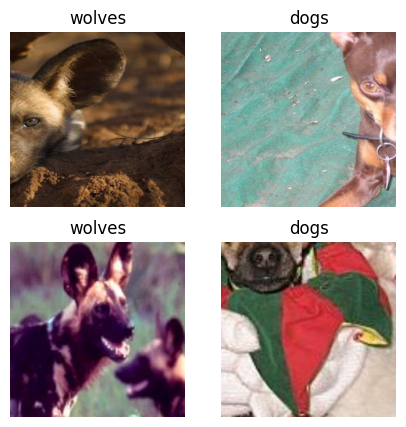

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {0: "dogs", 1: "wolves"}

plt.figure(figsize=(5, 5))
for i in range(4):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(2, 2, i+1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## 构建Resnet50网络

本章使用ResNet50模型。搭建好模型框架后，将权重参数加载到网络中。


In [7]:
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore import mint
from mindspore.common.initializer import Normal
from mindspore import dtype as mstype

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

In [8]:
class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel, dtype=mstype.float16)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init, dtype=mstype.float16)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init, dtype=mstype.float16)
        self.relu = mint.nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

In [9]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init, dtype=mstype.float16)
        self.norm1 = nn.BatchNorm2d(out_channel, dtype=mstype.float16)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init, dtype=mstype.float16)
        self.norm2 = nn.BatchNorm2d(out_channel, dtype=mstype.float16)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init, dtype=mstype.float16)
        self.norm3 = nn.BatchNorm2d(
            out_channel * self.expansion, dtype=mstype.float16)

        self.relu = mint.nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

In [10]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init, dtype=mstype.float16),
            nn.BatchNorm2d(channel * block.expansion,
                           gamma_init=gamma_init, dtype=mstype.float16)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

In [11]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = mint.nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=7, stride=2, weight_init=weight_init, dtype=mstype.float16)
        self.norm = nn.BatchNorm2d(64, dtype=mstype.float16)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(
            kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion,
                                 block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(
            128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(
            256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = mint.nn.AvgPool2d(kernel_size=1)
        # 全连接层
        self.fc = mint.nn.Linear(
            in_features=input_channel, out_features=num_classes, dtype=mstype.float16)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = mint.flatten(x, 1, -1)
        x = self.fc(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrianed_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrianed_ckpt, replace=True)
        param_dict = load_checkpoint(pretrianed_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)

### 模型微调

由于ResNet50中的预训练模型是针对ImageNet数据集中的1000个类别进行分类的，在本章只对狼和狗两个类别进行分类，所以需要重置预训练模型中的分类器，然后重新微调网络, 且在训练完成后，保存精度最高的ckpt文件(resnet50-best.ckpt)

In [12]:
import mindspore as ms

network = resnet50(pretrained=True)

# 全连接层输入层的大小
in_features = network.fc.in_features
# 输出通道数大小为狼狗分类数2
head = mint.nn.Linear(in_features, 2, dtype=mstype.float16)
# 重置全连接层
network.fc = head

# 平均池化层kernel size为7
avg_pool = mint.nn.AvgPool2d(kernel_size=7)
# 重置平均池化层
network.avg_pool = avg_pool


file_sizes: 100%|████████████████████████████| 102M/102M [00:13<00:00, 7.62MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:23.547.654 [mindspore/train/serialization.py:319] The type of conv1.weight:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:23.549.981 [mindspore/train/serialization.py:319] The type of norm.moving_mean:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:23.551.695 [mindspore/train/serialization.py:319] The type of norm.moving_variance:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730

#### 可视化模型预测

定义 `visualize_mode` 函数，可视化模型预测。

In [13]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(best_ckpt_path, val_ds):
    net = resnet50()
    # 全连接层输入层的大小
    in_features = net.fc.in_features
    # 输出通道数大小为狼狗分类数2
    head = mint.nn.Linear(in_features, 2, dtype=mstype.float16)
    # 重置全连接层
    net.fc = head
    # 平均池化层kernel size为7
    avg_pool = mint.nn.AvgPool2d(kernel_size=7)
    # 重置平均池化层
    net.avg_pool = avg_pool
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = train.Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0: "dogs", 1: "wolves"}
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image'], dtype=mstype.float16))
    # output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(5, 5))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

使用模型微调得到的resnet50-best.ckpt文件对验证集的狼和狗图像数据进行预测。若预测字体为蓝色表示预测正确，若预测字体为红色表示预测错误。


file_sizes: 100%|██████████████████████████| 94.3M/94.3M [00:17<00:00, 5.47MB/s]
Successfully downloaded file to ./resnet50-best.ckpt


[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:45.256.508 [mindspore/train/serialization.py:319] The type of conv1.weight:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:45.258.854 [mindspore/train/serialization.py:319] The type of norm.moving_mean:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:42:45.260.570 [mindspore/train/serialization.py:319] The type of norm.moving_variance:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730

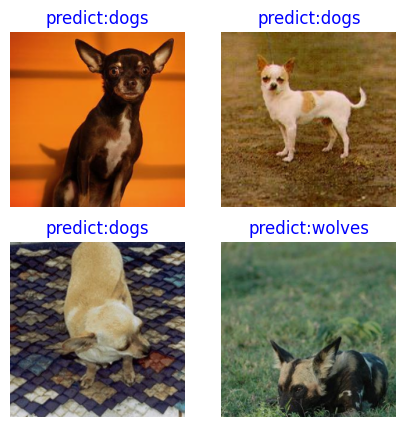

In [14]:
# download ckpt
resnet50_transfer_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/14-ResNet50_transfer/BestCheckpoint/resnet50-best.ckpt"
path = "./resnet50-best.ckpt"
ckpt_path = download(resnet50_transfer_url, path, replace=True)

visualize_model(ckpt_path, dataset_val)

### 固定特征进行训练后评估

使用固定特征进行训练的时候，需要冻结除最后一层之外的所有网络层。通过设置 `requires_grad = False` 冻结参数，以便不在反向传播中计算梯度。且在训练完成后，保存精度最高的ckpt文件(resnet50-best-freezing-param.ckpt)

In [15]:
net_work = resnet50(pretrained=True)

# 全连接层输入层的大小
in_features = net_work.fc.in_features
# 输出通道数大小为狼狗分类数2
head = mint.nn.Linear(in_features, 2, dtype=mstype.float16)
# 重置全连接层
net_work.fc = head

# 平均池化层kernel size为7
avg_pool = mint.nn.AvgPool2d(kernel_size=7)
# 重置平均池化层
net_work.avg_pool = avg_pool

# 冻结除最后一层外的所有参数
for param in net_work.get_parameters():
    if param.name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False


file_sizes: 100%|████████████████████████████| 102M/102M [00:07<00:00, 13.5MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:06.539.664 [mindspore/train/serialization.py:319] The type of conv1.weight:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:06.541.898 [mindspore/train/serialization.py:319] The type of norm.moving_mean:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:06.543.676 [mindspore/train/serialization.py:319] The type of norm.moving_variance:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730

#### 可视化模型预测

使用固定特征得到的resnet50-best-freezing-param.ckpt文件对验证集的狼和狗图像数据进行预测。若预测字体为蓝色即为预测正确，若预测字体为红色则预测错误。


file_sizes: 100%|██████████████████████████| 94.3M/94.3M [00:12<00:00, 7.60MB/s]
Successfully downloaded file to ./resnet50-best-freezing-param.ckpt


[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:29.954.880 [mindspore/train/serialization.py:319] The type of conv1.weight:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:29.957.206 [mindspore/train/serialization.py:319] The type of norm.moving_mean:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730164768,MainProcess):2025-09-28-22:43:29.959.060 [mindspore/train/serialization.py:319] The type of norm.moving_variance:Float32 in 'parameter_dict' is different from the type of it in 'net':Float16, then the type convert from Float32 to Float16 in the network. May consume additional memory and time
[WARNING] ME(20377:255085730

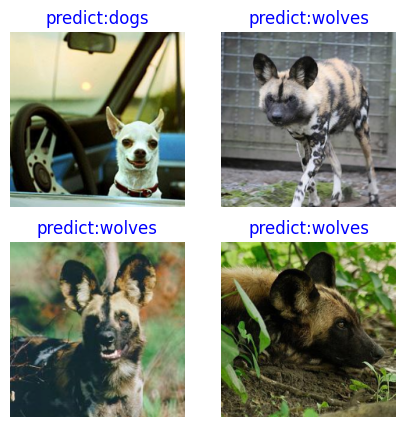

In [16]:
# download ckpt
resnet50_transfer_freezing_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/14-ResNet50_transfer/BestCheckpoint/resnet50-best-freezing-param.ckpt"
path = "./resnet50-best-freezing-param.ckpt"
best_ckpt_path = download(resnet50_transfer_freezing_url, path, replace=True)

visualize_model(best_ckpt_path, dataset_val)